# Homework 8: Problems
### ASTR-324, Spring 2017, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s17/astr-324-s17


## Problem 1: Principal Component Analysis

PCA applied to 4-D data for variable stars from the SDSS and LINEAR surveys:

-- SDSS u-g and g-i colors, 

-- LINEAR variability period (logP) and variability amplitude (A).

For more details, see Homework 1 - this is the same data sample.  

Read the data, run PCA (with four components), and then

a) plot P2 vs. P1 diagram, color-coded using P3 and P4 as in Homework 1. 
From Homework 1, retain the g-i vs. u-g and amplitude vs. logP diagrams, 
color-coded by the u-g and g-i colors, for visual comparison. Comment
what insights, if any, did PCA analysis bring. 

b) plot the g-i vs. u-g, amplitude vs. logP, P2 vs. P1 and P4 vs. P3 diagrams, 
color-coded using P1 and P2. Comment what insights, if any, did PCA analysis bring. 


## Problem 2: Regression and age-color relation for asteroids

We will use age and color data for asteroid families shown in figure 1 from the paper "An age–colour relationship for main-belt S-complex asteroids" by Jedicke et al. (2004, Nature 429, 275), see http://www.astro.washington.edu/users/ivezic/Publications/jedicke.pdf

Given these y(x) data (see below), with errors in both x and y, 
adapt the code introduced in 
[the last lecture](https://github.com/uw-astr-324-s17/astr-324-s17/blob/master/notebooks/Week-8-Thu.ipynb) 
by modifying the parabola (y(x) = a + b*x + c*x^2) fitter to fit instead
the following function

$$ y(x) = a + b*\left[1-exp\left(-(x/c)^d\right)\right].  $$

Important: here x is time, not log(time)! But when you plot, use log(time)
for x axis (see data below).

a) What are the the best-fit values and standard errors for 
parameters a, b, c and d? 

b) Show the marginal distributions of fitted parameters (hint: use plot_mcmc)

c) compare your best fit to the best fit from Jedicke et al. and comment

d) set all age errors to 1000 years (i.e. to 0.001 in Myr): 
do you get a different best fit? 

<br>
# Homework 1: Solutions

### Some useful definitions and functions

In [307]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.datasets import fetch_LINEAR_geneva

This astroML function adjusts matplotlib settings for a uniform feel in the 
textbook. Note that with `usetex=True`, fonts are rendered with $\LaTeX$. This 
may result in an error if $\LaTeX$ is not installed on your system.  In that 
case, you can set usetex to `False`.

In [308]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

Let's define a few more useful functions:

In [309]:
def black_bg_subplot(*args, **kwargs):
# copied from http://www.astroml.org/book_figures/chapter1/fig_moving_objects_multicolor.html
    """Create a subplot with black background"""
    kwargs['facecolor'] = 'k'
    ax = plt.subplot(*args, **kwargs)

    # set ticks and labels to white
    for spine in ax.spines.values():
        spine.set_color('w')

    for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        for child in tick.get_children():
            child.set_color('w')

    return ax

In [310]:
def compute_color2(vec1, vec2, kG=5.0, aG=0.8, kB=2.0, aB=1.2):
# adopted from http://www.astroml.org/book_figures/chapter1/fig_moving_objects_multicolor.html
    """
    Compute the scatter-plot color using code adapted from astroML
    http://www.astroml.org/book_figures/chapter1/fig_moving_objects_multicolor.html
    """
    # define the base color scalings
    # fudge factors aG and aB control the "redness" and "greenness"
    # fudge factors kG and kB control dynamic range of color coding
    # both a and k factors need some experimenting for the best results
    R = np.ones_like(vec1)
    G = aG * 10**(kG*vec1) 
    B = aB * 10**(kB*vec2) 

    # normalize color of each point to its maximum component
    RGB = np.vstack([R, G, B])
    RGB /= RGB.max(0)

    # return an array of RGB colors, which is shape (n_points, 3)
    return RGB.T

## Problem 1

First obtain LINEAR data for 6,146 stars using astroML built-in function: 

In [311]:
data = fetch_LINEAR_geneva()
# N.B. this is a 7-dimensional dataset
ug = data['ug']
gi = data['gi']
logP = data['logP']
A = data['amp']

In [312]:
# first plot diagrams as in HW #1
ugNorm = (ug-1.5)/(3.0-0.0)
giNorm = (gi-0.5)/(2.5+1.0)
color = compute_color2(ugNorm, giNorm, 5.0, 0.8, 2.0, 1.2)

# set up the plot
fig = plt.figure(figsize=(9, 7), facecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2,
                    bottom=0.1, top=0.93)

# plot the color-color plot
ax1 = black_bg_subplot(221)
ax1.scatter(ug, gi, c=color, s=0.9, lw=0)
ax1.set_xlim(0.0, 3.0)
ax1.set_ylim(-1.0, 2.5)
ax1.set_xlabel(r'${\rm u-g}$', color='w')
ax1.set_ylabel(r'${\rm g-i}$', color='w')

# plot the A vs. logP plot
ax2 = black_bg_subplot(222)
ax2.scatter(logP, A, c=color, s=0.9, lw=0)
ax2.set_xlim(-1.5, 0.5)
ax2.set_ylim(0.0, 1.5)
ax2.set_xlabel(r'${\rm logP \, (days)}$', color='w')
ax2.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='w')

And then do the PCA analysis...

In [313]:
from sklearn.decomposition import PCA
X = np.column_stack((ug, gi, logP, A))
pca = PCA(n_components=4, whiten=False)  
pca.fit(X)  # call the work horse 
comp = pca.transform(X) # compute the subspace projection of X
mean = pca.mean_ # length 4 mean of the data
components = pca.components_ # 4 x 4 matrix of components
var = pca.explained_variance_ # the length 4 array of eigenvalues
var_rat = pca.explained_variance_ratio_
# and now generate principal axes values
P1 = comp[:,0]
P2 = comp[:,1]
P3 = comp[:,2]
P4 = comp[:,3]
print np.mean(P1), np.min(P1), np.max(P1)
print np.mean(P2), np.min(P2), np.max(P2)
print np.mean(P3), np.min(P3), np.max(P3)
print np.mean(P4), np.min(P4), np.max(P4)

-1.16535482858e-15 -1.12365169024 100.519009806
-8.50894001821e-16 -2.1515679756 3.06310181457
-2.15613765407e-16 -1.84240860061 4.11681685076
-2.26596772224e-16 -1.33735693561 1.93296808404



Now compute RGB color based on P3 and P4

In [314]:
## and now use principal coordinates 
P3norm = P3/3.0
P4norm = P4/3.0 
# for the last four parameters, see compute_color2 above
colorP = compute_color2(P3norm, P4norm, 5.0, 0.8, 2.0, 1.2)

In [315]:
# plot the color-color plot
ax1 = black_bg_subplot(223)
ax1.scatter(P1, P2, c=colorP, s=0.9, lw=0)
ax1.set_xlim(-1.0, 1.0)
ax1.set_ylim(-1.5, 2.5)
ax1.set_xlabel(r'${\rm P_1}$', color='w')
ax1.set_ylabel(r'${\rm P_2}$', color='w')

# plot the A vs. logP plot
ax2 = black_bg_subplot(224)
ax2.scatter(P3, P4, c=colorP, s=0.9, lw=0)
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlabel(r'${\rm P_3}$', color='w')
ax2.set_ylabel(r'${\rm P_4}$', color='w')

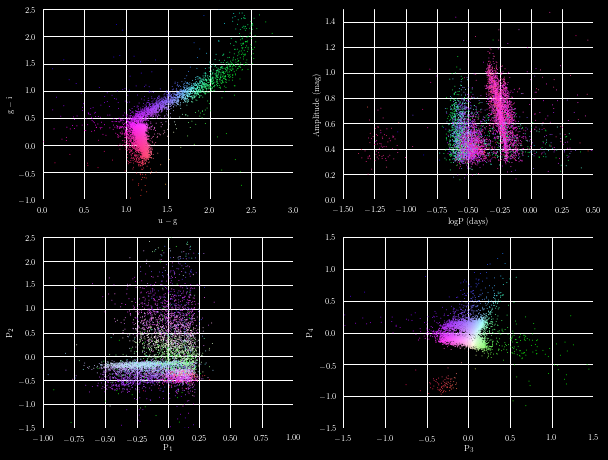

In [316]:
plt.show()

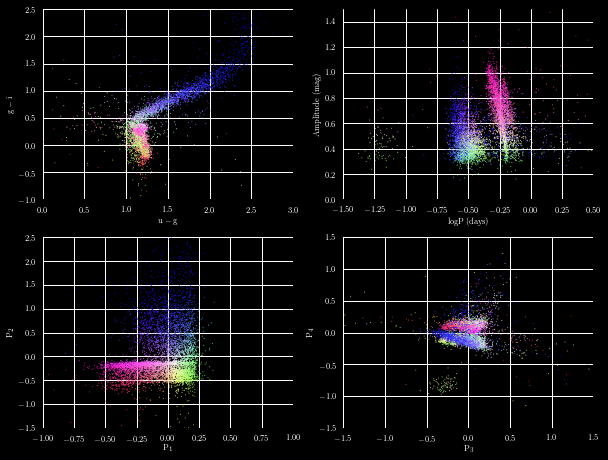

In [317]:
## now use principal coordinates P1 and P2 to define color
P1norm = P1/3.0
P2norm = P2/3.0 
# for the last four parameters, see compute_color2 above
colorP12 = compute_color2(P1norm, P2norm, 5.0, 0.8, 2.0, 1.2)

# set up the plot
fig = plt.figure(figsize=(9, 7), facecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2,
                    bottom=0.1, top=0.93)

# plot the color-color plot
ax1 = black_bg_subplot(221)
ax1.scatter(ug, gi, c=colorP12, s=0.9, lw=0)
ax1.set_xlim(0.0, 3.0)
ax1.set_ylim(-1.0, 2.5)
ax1.set_xlabel(r'${\rm u-g}$', color='w')
ax1.set_ylabel(r'${\rm g-i}$', color='w')

# plot the A vs. logP plot
ax2 = black_bg_subplot(222)
ax2.scatter(logP, A, c=colorP12, s=0.9, lw=0)
ax2.set_xlim(-1.5, 0.5)
ax2.set_ylim(0.0, 1.5)
ax2.set_xlabel(r'${\rm logP \, (days)}$', color='w')
ax2.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='w')

# plot the color-color plot
ax1 = black_bg_subplot(223)
ax1.scatter(P1, P2, c=colorP12, s=0.9, lw=0)
ax1.set_xlim(-1.0, 1.0)
ax1.set_ylim(-1.5, 2.5)
ax1.set_xlabel(r'${\rm P_1}$', color='w')
ax1.set_ylabel(r'${\rm P_2}$', color='w')

# plot the A vs. logP plot
ax2 = black_bg_subplot(224)
ax2.scatter(P3, P4, c=colorP12, s=0.9, lw=0)
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlabel(r'${\rm P_3}$', color='w')
ax2.set_ylabel(r'${\rm P_4}$', color='w')

plt.show()

## Problem 2

These age and color data for asteroid families are taken
from the paper Jedicke et al. (2004, Nature 429, 275), see fig. 1 in http://www.astro.washington.edu/users/ivezic/Publications/jedicke.pdf



In [318]:
# Age is measured in 10^6 yrs (Myr)
# Log10(age) and error (of Log(Age))
logAge = np.asarray([3.398, 2.477, 3.398, 3.477, 3.301, 1.699, 2.699, 0.763,
         2.301, 3.079,  3.176, 0.398])
LageErr = np.asarray([0.087, 0.145, 0.174, 0.145, 0.109, 0.347, 0.174, 0.015,
          0.217, 0.145, 0.145, 0.434])
# SDSS principal asteroid color PC1 and its error (per family)
PC1 = np.asarray([0.620, 0.476, 0.523, 0.582, 0.460, 0.479, 0.432, 0.351, 
       0.427, 0.522, 0.532, 0.311])
PC1err = np.asarray([0.005, 0.015, 0.007, 0.011, 0.005, 0.032, 0.033, 0.047,
        0.021, 0.015, 0.022, 0.027])
# time/age on linear axes
age = 10**logAge
# and standard error propagation (although errors can be large)
ageErr = age * LageErr * np.log(10)
# set ageErr to 1000 years for all data points
# ageErr = 0.001 + 0*ageErr

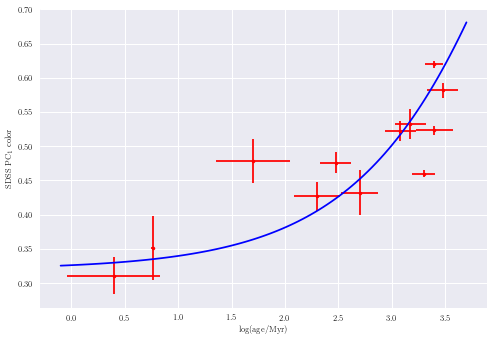

In [319]:
# let's take a quick look at the data to verify that it looks
# similar to fig. 1 from Jedicke et al. 
logT = np.linspace(-0.1, 3.7, 100)
time = np.power(10,logT)
# the best fit from Jedicke et al. 
color = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,color, c='blue')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')
plt.show() 

In [320]:
### now let's redo doMCMCparabola from the lecture to be able to fit instead
### y = a + b*[1-exp(-(x/c)^d)]  
def doMCMCasteroids(xObs, yObs, xErr, yErr, doXerror = False, nChain = 10000, nBurn = 2000): 
    def model(xObs, yObs, xErr, yErr, doXerror): 
        a = pymc.Uniform('a', 0.3, 0.35, value= 0.31)
        b = pymc.Uniform('b', 0, 10, value= 1.0)
        c = pymc.Uniform('c', 0, 100000, value= 20000.0)
        d = pymc.Uniform('d', 0, 5, value= 1.0)

        if (doXerror):
            xLatent = pymc.Normal('x', mu=xObs, tau=(xErr)**-2)  
        else:
            xLatent = xObs 
        
        @pymc.deterministic()
        def parabola(x=xLatent, a=a, b=b, c=c, d=d):
            return a + b*(1-np.exp(-(x/c)**d))
         
        y = pymc.Normal('y', mu=parabola, tau=(yErr)**-2, value=yObs, observed=True)
        return locals()

    myModel = pymc.MCMC(model(xObs,yObs, xErr, yErr, doXerror))
    myModel.sample(nChain, nBurn, 1)
    traces = [myModel.trace(s)[:] for s in ['a', 'b', 'c', 'd']]
    M = pymc.MAP(myModel)
    M.fit()
    fit_vals = (M.a.value, M.b.value, M.c.value, M.d.value)
    return traces, fit_vals

In [321]:
import pymc as pymc
#import seaborn as sns
# run MCMC 
traces, fit_vals = doMCMCasteroids(age, PC1, ageErr, PC1err, True, 50000, 10000) 

 [-----------------100%-----------------] 50000 of 50000 complete in 10.8 sec

In [322]:
print "BASIC STATS:"
print 'a:', np.mean(traces[0]), np.median(traces[0]), np.std(traces[0])
print 'b:', np.mean(traces[1]), np.median(traces[1]), np.std(traces[1])
print 'c:', np.mean(traces[2]), np.median(traces[2]), np.std(traces[2])
print 'd:', np.mean(traces[3]), np.median(traces[3]), np.std(traces[3])
print fit_vals

BASIC STATS:
a: 0.332365258952 0.335017041373 0.013197073382
b: 1.53327788476 1.29030932141 0.719616972743
c: 63298.8954535 64844.9767586 23274.3015201
d: 0.486572177154 0.456685335908 0.110995606337
(array(0.3095821220936151), array(1.237671453144497), array(85066.70482886757), array(0.3684258024282306))


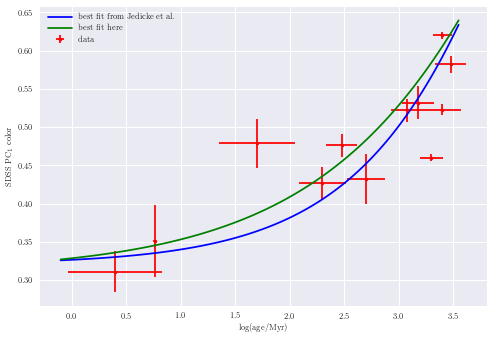

In [323]:
# let's take a quick look at the data 
logT = np.linspace(-0.1, 3.55, 100)
time = np.power(10,logT)
color = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
aFit = fit_vals[0]
bFit = fit_vals[1] 
cFit = fit_vals[2] 
dFit = fit_vals[3] 
colorFit = aFit + bFit*(1-np.exp(-(time/cFit)**dFit))

ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,color, c='blue', label='best fit from Jedicke et al.')
ax.plot(logT,colorFit, c='green', label='best fit here')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='data')
plt.legend()
plt.show() 

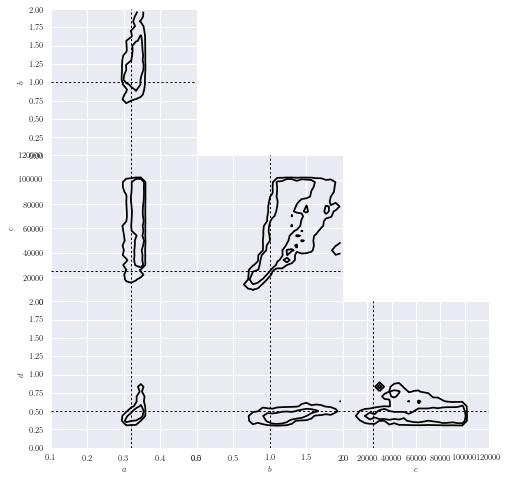

Best-fit values here (abcd):
0.309582122094 1.23767145314 85066.7048289 0.368425802428


In [324]:
###  look at the posterior pdf p(b,m) from MCMC 
# a helper routine for more informative plots
from astroML.plotting.mcmc import plot_mcmc

labels = ['$a$', '$b$', '$c$', '$d$']
limits = [(0.1, 0.5), (0, 2.0), (0,120000), (0, 2.0)]
jedicke = [0.32, 1.0, 25000, 0.5]

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=jedicke, fig=fig,
          bins=30, colors='k')

plt.show()

print 'Best-fit values here (abcd):'
print aFit, bFit, cFit, dFit